In [ ]:
import os, zipfile, shutil,re
# import torch
# from torch.utils.data import DataLoader
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.cm as cm

In [ ]:
print(keras.version())

3.10.0


In [ ]:
print(tf.__version__)

2.19.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



=== MERGING ZIP: /content/drive/MyDrive/DATASET - DL/train2.zip → /content/drive/MyDrive/DATASET - DL/train
Detected folder inside zip: train
MERGE COMPLETE: /content/drive/MyDrive/DATASET - DL/train2.zip

=== MERGING ZIP: /content/drive/MyDrive/DATASET - DL/test2.zip → /content/drive/MyDrive/DATASET - DL/valid
Detected folder inside zip: test
MERGE COMPLETE: /content/drive/MyDrive/DATASET - DL/test2.zip

=== MERGING ZIP: /content/drive/MyDrive/DATASET - DL/train.zip → /content/drive/MyDrive/DATASET - DL/train
Detected folder inside zip: train
MERGE COMPLETE: /content/drive/MyDrive/DATASET - DL/train.zip

=== MERGING ZIP: /content/drive/MyDrive/DATASET - DL/valid.zip → /content/drive/MyDrive/DATASET - DL/valid
Detected folder inside zip: valid
MERGE COMPLETE: /content/drive/MyDrive/DATASET - DL/valid.zip

=== FIXING DATASET: /content/drive/MyDrive/DATASET - DL/train ===
Merged folder fresh into Fresh and removed original.
Merged folder rotten into Spoiled and removed original.
Moving 

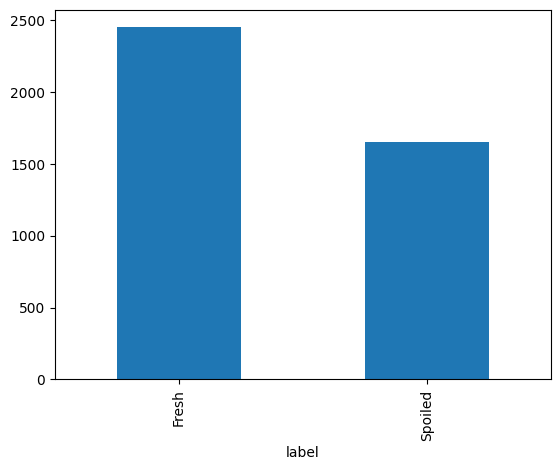

In [ ]:
import os
import shutil
import re
import pandas as pd
import zipfile

DATA_ROOT = "/content/drive/MyDrive/DATASET - DL"
TRAIN = os.path.join(DATA_ROOT, "train")
VALID = os.path.join(DATA_ROOT, "valid")

train_zip2 = os.path.join(DATA_ROOT, "train2.zip")
test_zip2  = os.path.join(DATA_ROOT, "test2.zip")

train_zip  = os.path.join(DATA_ROOT, "train.zip")
valid_zip  = os.path.join(DATA_ROOT, "valid.zip")


def merge_from_zip(zip_path, target_dir):
    if not os.path.exists(zip_path):
        print(f"WARNING: Zip file not found: {zip_path}. Skipping merge.")
        return

    print(f"\n=== MERGING ZIP: {zip_path} → {target_dir}")

    temp_extract = os.path.join(DATA_ROOT, "__temp_extract__")
    if os.path.exists(temp_extract):
        shutil.rmtree(temp_extract)
    os.makedirs(temp_extract)

    try:
        with zipfile.ZipFile(zip_path, "r") as z:
            z.extractall(temp_extract)
    except zipfile.BadZipFile:
        print(f"ERROR: {zip_path} is a bad zip file. Skipping.")
        shutil.rmtree(temp_extract)
        return

    root_items = os.listdir(temp_extract)
    source_root = temp_extract
    if len(root_items) == 1 and os.path.isdir(os.path.join(temp_extract, root_items[0])):
        source_root = os.path.join(temp_extract, root_items[0])
        print("Detected folder inside zip:", root_items[0])
    elif len(root_items) > 1:
        print("No single root folder detected, extracting directly into temp_extract.")
    else:
        print("Zip appears empty or only contains files at root level.")

    os.makedirs(target_dir, exist_ok=True)

    for item in os.listdir(source_root):
        src = os.path.join(source_root, item)
        dst = os.path.join(target_dir, item)

        if os.path.isdir(src):
            for root, dirs, files in os.walk(src):
                rel = os.path.relpath(root, src)
                out_dir = os.path.join(dst, rel)
                os.makedirs(out_dir, exist_ok=True)
                for f in files:
                    src_file_path = os.path.join(root, f)
                    dst_file_path = os.path.join(out_dir, f)
                    if os.path.exists(dst_file_path):
                        base, ext = os.path.splitext(f)
                        i = 1
                        while os.path.exists(os.path.join(out_dir, f"{base}_{i}{ext}")):
                            i += 1
                        dst_file_path = os.path.join(out_dir, f"{base}_{i}{ext}")
                    shutil.copy2(src_file_path, dst_file_path)
        else:
            if os.path.exists(dst):
                base, ext = os.path.splitext(item)
                i = 1
                while os.path.exists(os.path.join(target_dir, f"{base}_{i}{ext}")):
                    i += 1
                dst = os.path.join(target_dir, f"{base}_{i}{ext}")
            shutil.copy2(src, dst)

    shutil.rmtree(temp_extract)
    print("MERGE COMPLETE:", zip_path)


if os.path.exists(TRAIN): shutil.rmtree(TRAIN)
if os.path.exists(VALID): shutil.rmtree(VALID)
os.makedirs(TRAIN, exist_ok=True)
os.makedirs(VALID, exist_ok=True)

zip_files_to_merge = [
    (train_zip2, TRAIN),
    (test_zip2, VALID),
    (train_zip, TRAIN),
    (valid_zip, VALID)
]

for zip_path, target_dir in zip_files_to_merge:
    merge_from_zip(zip_path, target_dir)


def hard_fix_dataset(root_dir):
    print(f"\n=== FIXING DATASET: {root_dir} ===")
    TARGETS = ["Fresh", "Spoiled"]
    for t in TARGETS:
        os.makedirs(os.path.join(root_dir, t), exist_ok=True)

    RENAME = {
        "fresh": "Fresh",
        "rotten": "Spoiled",
        "spoiled": "Spoiled",
        "half-fresh": "Spoiled",
        "half_fresh": "Spoiled",
        "half fresh": "Spoiled",
    }

    for f in os.listdir(root_dir):
        full = os.path.join(root_dir, f)
        if not os.path.isdir(full):
            continue

        low = f.lower()
        if low in RENAME:
            corrected = RENAME[low]
            dst = os.path.join(root_dir, corrected)

            if os.path.exists(dst) and full != dst:
                for item in os.listdir(full):
                    src_item = os.path.join(full, item)
                    dst_item = os.path.join(dst, item)

                    if os.path.exists(dst_item):
                        base, ext = os.path.splitext(item)
                        i = 1
                        while os.path.exists(os.path.join(dst, f"{base}_{i}{ext}")):
                            i += 1
                        dst_item = os.path.join(dst, f"{base}_{i}{ext}")
                    shutil.move(src_item, dst_item)
                shutil.rmtree(full)
                print(f"Merged folder {f} into {corrected} and removed original.")
                continue

            if full != dst:
                print(f"Renaming folder → {f} → {corrected}")
                shutil.move(full, dst)


    PATTERN = {
        "Fresh": re.compile(r"fresh", re.IGNORECASE),
        "Spoiled": re.compile(r"(spoiled|rotten|half[\s\-_]*fresh)", re.IGNORECASE)
    }

    files_in_root = [f for f in os.listdir(root_dir) if os.path.isfile(os.path.join(root_dir, f))]

    for fname in files_in_root:
        src = os.path.join(root_dir, fname)

        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        matched = None
        for cls, pat in PATTERN.items():
            if pat.search(fname):
                matched = cls
                break

        if matched:
            dst_dir = os.path.join(root_dir, matched)
            os.makedirs(dst_dir, exist_ok=True)
            dst = os.path.join(dst_dir, fname)

            if os.path.exists(dst):
                base, ext = os.path.splitext(fname)
                i = 1
                while os.path.exists(os.path.join(dst_dir, f"{base}_{i}{ext}")):
                    i += 1
                dst = os.path.join(dst_dir, f"{base}_{i}{ext}")

            print(f"Moving file {fname} → {matched}")
            shutil.move(src, dst)
        else:
            print(f"WARNING: File {fname} did not match any class pattern. Leaving in root.")

    print(f"DONE FIXING {root_dir}")

hard_fix_dataset(TRAIN)
hard_fix_dataset(VALID)


def rebuild_labels(root_dir):
    rows = []
    if not os.path.exists(root_dir):
        print(f"WARNING: Directory {root_dir} does not exist for rebuilding labels. Returning empty DataFrame.")
        return pd.DataFrame(columns=["filename", "label"])

    for cls in os.listdir(root_dir):
        cls_path = os.path.join(root_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        if cls not in ["Fresh", "Spoiled"]:
            print(f"WARNING: Unexpected directory found in {root_dir}: {cls}. Skipping.")
            continue

        for f in os.listdir(cls_path):
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                rows.append({
                    "filename": os.path.join(cls_path, f),
                    "label": cls
                })

    return pd.DataFrame(rows)


def consolidate_labels(df):
    if 'label' in df.columns:
        df['label'] = df['label'].replace('Half-Fresh', 'Spoiled')
    return df


train_label = rebuild_labels(TRAIN)
train_label = consolidate_labels(train_label)
test_label  = rebuild_labels(VALID)
test_label = consolidate_labels(test_label)

print("\nTrain distribution:")
print(train_label['label'].value_counts().plot(kind='bar'))

print("\nValid distribution:")
print(test_label['label'].value_counts().plot(kind='bar'))

print("\nSample rows:")
print(train_label.head())

In [ ]:
train_label2, val_label = train_test_split(
    train_label,
    test_size=0.2,
    stratify=train_label['label'],
    random_state=42
)

In [ ]:
x_col = "filename"
y_col = "label"
batch_size = 16
epochs = 20
img_rows, img_cols = 224, 224

print('Using : ', img_rows, img_cols)

train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest'
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(
    dataframe = train_label2,
    x_col = x_col,
    y_col = y_col,
    target_size = (img_rows, img_cols),
    shuffle = True,
    class_mode = "categorical",
    batch_size = batch_size
)

val_gen = valid_datagen.flow_from_dataframe(
    dataframe=val_label,
    x_col=x_col,
    y_col=y_col,
    classes=["Fresh", "Spoiled"],
    target_size=(img_rows, img_cols),
    shuffle=False,
    class_mode="categorical",
    batch_size=batch_size
)

test_gen = valid_datagen.flow_from_dataframe(
    dataframe=test_label,
    x_col=x_col,
    y_col=y_col,
    classes=["Fresh", "Spoiled"],
    target_size=(img_rows, img_cols),
    shuffle=False,
    class_mode="categorical",
    batch_size=batch_size
)
print("\nClass indices (TRAIN):", train_gen.class_indices)
print("Class indices (VALID):", val_gen.class_indices)
print("Class indices (TEST):", test_gen.class_indices)

Using :  224 224
Found 3282 validated image filenames belonging to 2 classes.
Found 821 validated image filenames belonging to 2 classes.
Found 1431 validated image filenames belonging to 2 classes.

Class indices (TRAIN): {'Fresh': 0, 'Spoiled': 1}
Class indices (VALID): {'Fresh': 0, 'Spoiled': 1}
Class indices (TEST): {'Fresh': 0, 'Spoiled': 1}


In [ ]:
DATA_ROOT = "/content/drive/MyDrive/DATASET - DL"

base_model = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(img_rows, img_cols, 3))

for layer in base_model.layers[-30:]:
    layer.trainable = True

model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax')
     ])


model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

history = model.fit(
      train_gen,
      epochs=epochs,
      validation_data=val_gen
)

save_path = DATA_ROOT + "/MobileNetV2_FINETUNING_224.keras"
model.save(save_path)

print("Save finetuning")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,620,610 (10.00 MB)

 Trainable params: 2,585,730 (9.86 MB)

 Non-trainable params: 34,880 (136.25 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.5982 - loss: 0.9324 - val_accuracy: 0.7868 - val_loss: 0.4518
Epoch 2/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 172s 834ms/step - accuracy: 0.7295 - loss: 0.6436 - val_accuracy: 0.8745 - val_loss: 0.2792
Epoch 3/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 171s 828ms/step - accuracy: 0.8203 - loss: 0.4280 - val_accuracy: 0.9111 - val_loss: 0.1918
Epoch 4/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 171s 827ms/step - accuracy: 0.8379 - loss: 0.3976 - val_accuracy: 0.9367 - val_loss: 0.1522
Epoch 5/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 168s 814ms/step - accuracy: 0.8747 - loss: 0.3175 - val_accuracy: 0.9415 - val_loss: 0.1368
Epoch 6/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 164s 798ms/step - accuracy: 0.8934 - loss: 0.2720 - val_accuracy: 0.9659 - val_loss: 0.0840
Epoch 7/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 163s 792ms/step - accuracy: 0.9099 - loss: 0.2293 - val_accuracy: 0.9708 - val_loss: 0.0769
Epoch 8/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 162s 784ms/step - accuracy: 0.9300 - lo

In [ ]:
# save_path = "/content/drive/MyDrive/DATASET - DL/MobileNetV2_FINETUNED_224.keras"
model.save("/content/MobileNetV2_FINETUNED_224.keras")

print("Save finetuning")

Save finetuning


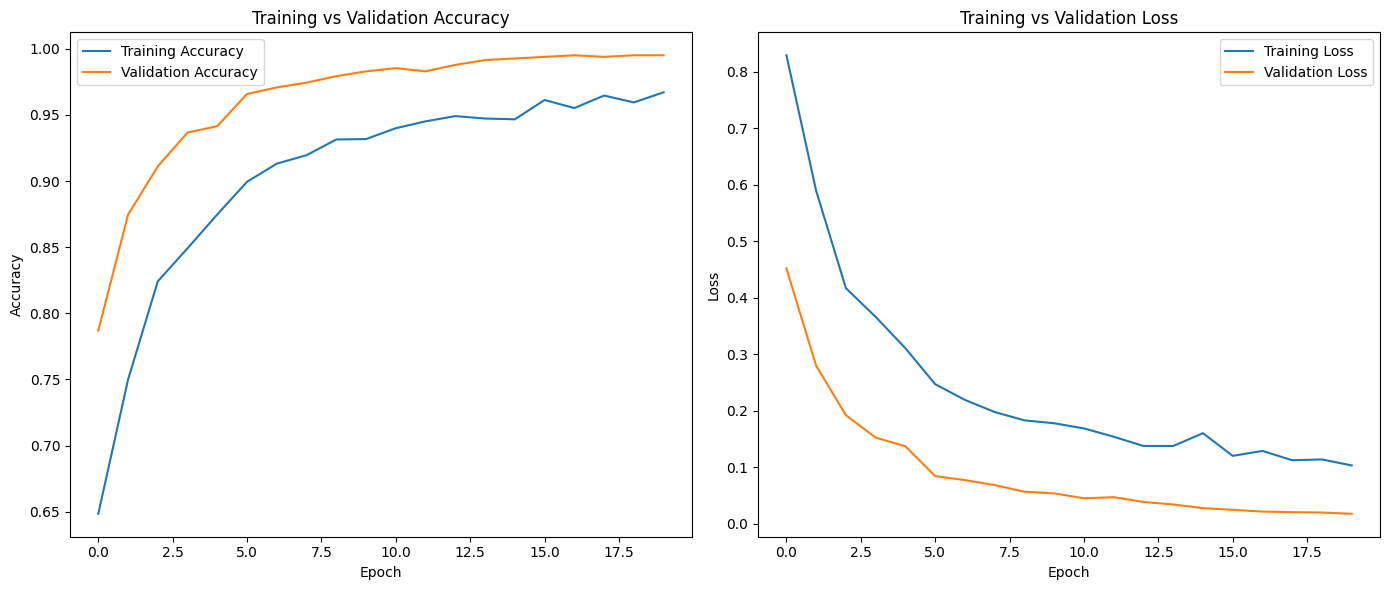

In [ ]:
plt.figure(figsize=(14,6))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Training vs Validation Loss')

plt.tight_layout()
plt.show()


90/90 ━━━━━━━━━━━━━━━━━━━━ 70s 677ms/step


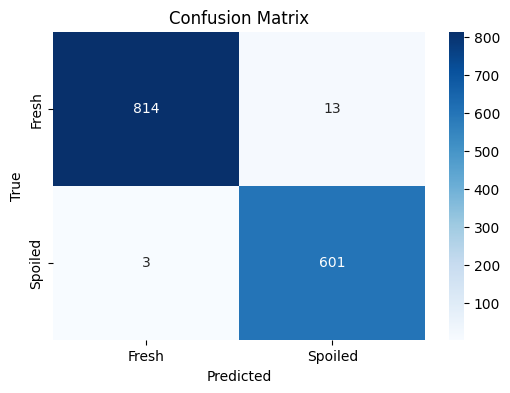

              precision    recall  f1-score   support

       Fresh       1.00      0.98      0.99       827
     Spoiled       0.98      1.00      0.99       604

    accuracy                           0.99      1431
   macro avg       0.99      0.99      0.99      1431
weighted avg       0.99      0.99      0.99      1431



In [ ]:
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ground truth dari generator
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))